This notebook reproduces figure 3, demonstrating the equivalence of atemporal/temporal execution for a single phasor neuron with a single input.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
from models import *

In [4]:
from scipy.stats import pearsonr

In [5]:
limit_gpus()
set_gpu(None)

In [6]:
dpi=100

In [7]:
n = 51

We a neuron being driven with different phases which it can reproduce. Using multiple neurons addressed with the identity matrix just allows this calculation to be done in parallel. 

In [8]:
wt = np.identity(n)

In [9]:
n_in, n_out = wt.shape

The input phases which will be reproduced by the neuron.

In [10]:
phases = np.linspace(-0.95, 0.95, n_in).reshape(1,n_in)

Setup the model to execute on.

In [11]:
model = keras.Sequential([layers.Input(n_in), CmpxLinear(n_out, leakage=-0.4)])

In [12]:
model.layers[0].w.assign(wt);

Do the atemporal execution

In [13]:
model(phases)

<tf.Tensor: shape=(1, 51), dtype=float32, numpy=
array([[-0.95      , -0.912     , -0.874     , -0.836     , -0.798     ,
        -0.76      , -0.722     , -0.684     , -0.646     , -0.608     ,
        -0.57      , -0.532     , -0.494     , -0.456     , -0.418     ,
        -0.38      , -0.342     , -0.304     , -0.266     , -0.228     ,
        -0.19      , -0.152     , -0.114     , -0.07600001, -0.038     ,
         0.        ,  0.038     ,  0.07600001,  0.114     ,  0.152     ,
         0.19      ,  0.228     ,  0.266     ,  0.304     ,  0.342     ,
         0.38      ,  0.418     ,  0.456     ,  0.494     ,  0.532     ,
         0.57      ,  0.608     ,  0.646     ,  0.684     ,  0.722     ,
         0.76      ,  0.798     ,  0.836     ,  0.874     ,  0.912     ,
         0.95      ]], dtype=float32)>

In [14]:
clayer = model.layers[0]
clayer.max_step = 0.01

In [15]:
"""
Convert real-valued phases into a spike train for the model in this notebook.
A more general version of this function is provided in utils.py. 
"""

def phase_to_train(x, period=1.0, reps=3):
        n_batch = x.shape[0]
        output = []

        for b in range(n_batch):
            n = x.shape[1]
            t_phase0 = period/2.0

            inds = np.arange(0,n)
            inds = np.tile(inds, reps)

            times = x[b,:] * t_phase0 + t_phase0
            times = np.tile(times, reps)

            #create a list of time offsets to move spikes forward by T for repetitions
            offsets = np.arange(0, reps).reshape(-1,1)
            offsets = np.repeat(offsets, n, axis=1)
            offsets = np.ravel(offsets) * period

            times += offsets
            times = times.ravel()
            
            output.append( (inds, times) )
        
        return output

In [16]:
in_spikes = phase_to_train(phases)

Text(0, 0.5, 'Spike Time')

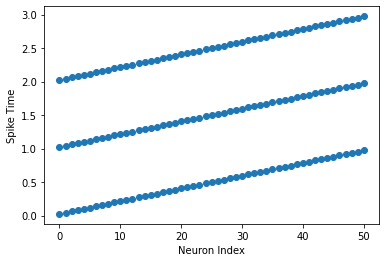

In [17]:
plt.scatter(in_spikes[0][0], in_spikes[0][1])
plt.xlabel("Neuron Index")
plt.ylabel("Spike Time")

Carry out dynamic execution with the spike train above as an input

In [18]:
out_spikes = clayer.call_dynamic(in_spikes, save_solutions=True, solver="heun")

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


In [19]:
sol = clayer.solutions[0]

Text(0.5, 1.0, 'Neuron Current')

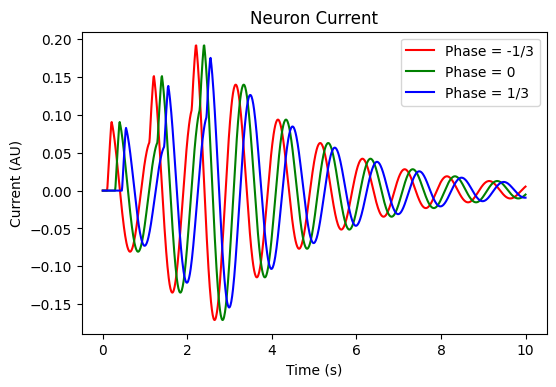

In [54]:
phase_inds = [7,17,25]
phase_lbls = ["Phase = -1/3", "Phase = 0", "Phase = 1/3"]
colors = ["red", "green", "blue"]

plt.figure(dpi=dpi)
for (i,pltind) in enumerate(phase_inds):
    plt.plot(sol.t, np.real(sol.y)[pltind:pltind+1,:].transpose(), label=phase_lbls[i], color=colors[i]);
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Current (AU)")
plt.title("Neuron Current")

In [55]:
threshold = clayer.threshold

Text(0.5, 1.0, 'Neuron Voltage')

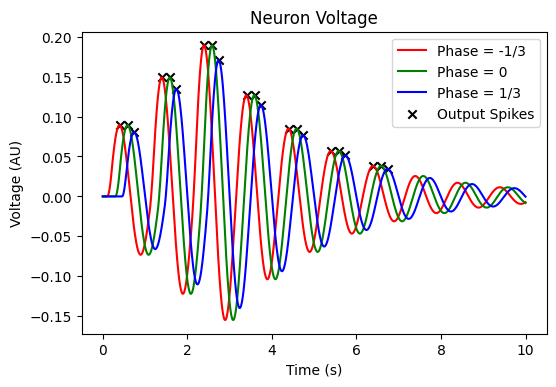

In [56]:
plt.figure(dpi=dpi)
for (i,pltind) in enumerate(phase_inds):
    plt.plot(sol.t, np.imag(sol.y)[pltind:pltind+1,:].transpose(), label=phase_lbls[i], color=colors[i]);
    
    n0_inds = np.where(out_spikes[0][0] == pltind)
    n0_tms = out_spikes[0][1][n0_inds]
    v_tms = np.concatenate([np.where(t == sol.t) for t in n0_tms])
    n0_spkz = sol.y[pltind, v_tms]
    if i == 1:
        plt.scatter(np.real(n0_tms), np.imag(n0_spkz), marker="x", color="black", label="Output Spikes")
    else:
        plt.scatter(np.real(n0_tms), np.imag(n0_spkz), marker="x", color="black")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Voltage (AU)")
plt.title("Neuron Voltage")

Text(0.5, 1.0, 'Single Neuron Current & Voltage')

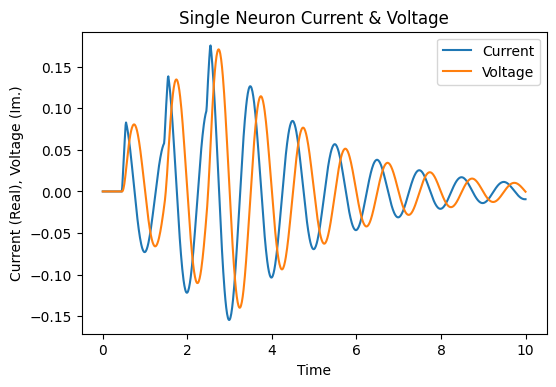

In [22]:
plt.figure(dpi=dpi)
pltind = 25
plt.plot(sol.t, np.real(sol.y)[pltind:pltind+1,:].transpose(), label="Current");
plt.plot(sol.t, np.imag(sol.y)[pltind:pltind+1,:].transpose(), label="Voltage");
plt.legend()
plt.xlabel("Time")
plt.ylabel("Current (Real), Voltage (Im.)")
plt.title("Single Neuron Current & Voltage")

In [23]:
pltind = 0
n0_inds = np.where(out_spikes[0][pltind] == 0)
n0_tms = out_spikes[pltind][1][n0_inds]
v_tms = np.concatenate([np.where(t == sol.t) for t in n0_tms])
n0_spkz = sol.y[pltind, v_tms]

Text(0.5, 1.0, 'Neuron Phase Plot')

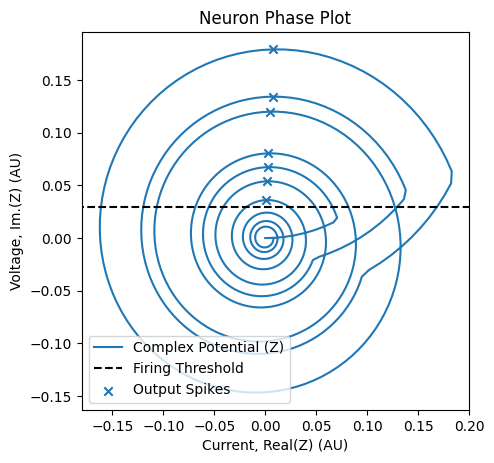

In [32]:
plt.figure(dpi=dpi, figsize=(5,5))
plt.plot(np.real(sol.y)[pltind,:], np.imag(sol.y)[pltind,:], label="Complex Potential (Z)")
plt.plot([-0.25, 0.25], [threshold, threshold], '--', color="black",label="Firing Threshold")
plt.scatter(np.real(n0_spkz), np.imag(n0_spkz), marker="x", label="Output Spikes")
plt.xlim(-0.18, 0.20)
plt.xlabel("Current, Real(Z) (AU)")
plt.ylabel("Voltage, Im.(Z) (AU)")
plt.legend(loc="lower left")
plt.title("Neuron Phase Plot")

Text(0.5, 1.0, 'Spiking Drive and Response')

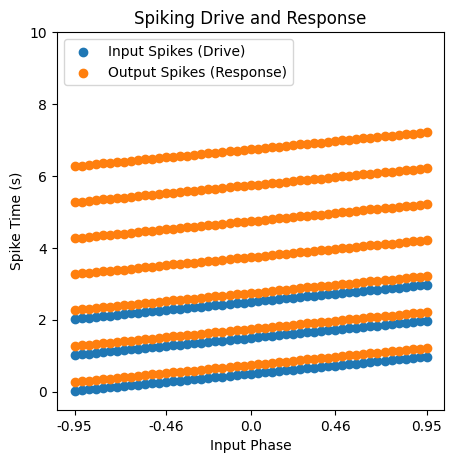

In [25]:
lblinds = [0, 13, 25, 37, 50]

plt.figure(dpi=dpi, figsize=(5,5))
plt.scatter(in_spikes[0][0], in_spikes[0][1], label="Input Spikes (Drive)")
plt.scatter(out_spikes[0][0], out_spikes[0][1], label="Output Spikes (Response)")
plt.xticks(lblinds, np.around(phases.ravel()[lblinds], decimals=2));
plt.xlabel("Input Phase")
plt.ylabel("Spike Time (s)")
plt.ylim(-0.5,10)
plt.legend(loc="upper left")
plt.title("Spiking Drive and Response")

In [26]:
"""
Decode spike trains into real-valued phases for the model in this notebook.
A more general version of this function is provided in utils.py. 
"""

def train_to_phase(trains, repeats=3, period=1.0, depth=0, n_outputs=20):
        n_b = len(trains)

        outputs = []
        for i in range(n_b):
            out_i, out_t = trains[i]
            phases = np.nan * np.zeros((repeats, n_outputs), "float")

            #assuming eigenfrenquency is same as 1/period
            offset = period/4.0
            #compensate for the delay in turning current into voltage & moving deeper in layers
            offset = (depth+1)*offset

            for j in range(repeats):
                #find the start and stop of the period for this cycle
                tcenter = j*period + offset
                halfcycle = period/2.0
                tstart = tcenter - halfcycle
                tstop =  tcenter + halfcycle
                #print(str(tstart) + " " + str(tstop))
                
                
                #grab the corresponding indices and values from the solution
                inds = (out_t > tstart) * (out_t < tstop)
                
                for ind in inds:
                    phase = (out_t[ind] - offset) % period
                    phase = 2.0 * phase - 1.0

                    phases[j, out_i[ind]] = phase

            outputs.append(phases)

        return outputs

In [27]:
op = train_to_phase(out_spikes, repeats=5, n_outputs=n)

In [28]:
corr = np.mean([pearsonr(phases.ravel(), op[0][i]) for i in range(5)],axis=0)

Text(0.5, 1.0, 'Correlation, Input & Output Values\nof Identity Neuron')

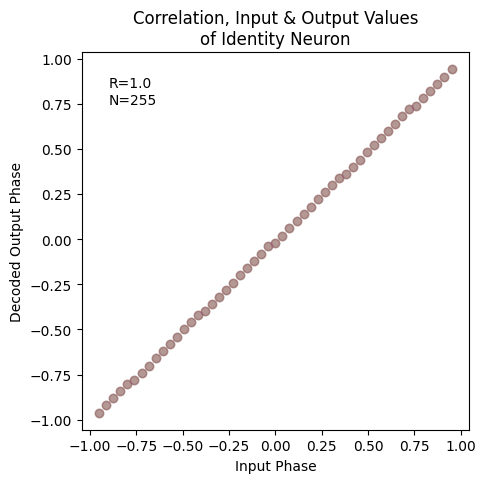

In [48]:
plt.figure(dpi=dpi, figsize=(5,5))
for i in range(5):
    plt.scatter(phases, op[0][i], alpha=0.2)
    
plt.xlabel("Input Phase")
plt.ylabel("Decoded Output Phase")
plt.text(-.90, .75, "R="+str(np.around(corr[0], decimals=2))+"\nN="+str(5*len(op)*n_in) )
plt.title("Correlation, Input & Output Values\nof Identity Neuron")